# Data Analysis of Text

## Subhadarshi Panda

- Topic Modeling using LDA

## Topic Modeling

Topic Modeling is a technique to extract the hidden topics from large volumes of text.

## LDA
LDA is a topic modeling technique:

- Each text sample is collection of topics in a certain proportion

- Each topic is a collection of keywords in a certain proportion

## Clustering

Clustering is the task of dividing the data points into a number of groups such that data points in the same groups are more similar to other data points in the same group and dissimilar to the data points in other groups.

## Import Packages
<script>
    console.log("Hello. You'll see this printed in your browser's DevTools / Console. Feel free to delete this line.");
    document.querySelector('head').innerHTML += '<style>.slides { zoom: 1.0 !important; }</style>';
</script>

In [2]:
import sys
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tqdm
from tqdm import tqdm

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Load Dataset

### A Million News Headlines
News headlines from 2003 to 2017

https://www.kaggle.com/therohk/million-headlines/data#

In [3]:
df_all = pd.read_csv('million-headlines/abcnews-date-text.csv')

# get year from date and put that in a new column "year"
df_all['year'] = df_all['publish_date'].apply(lambda s: str(s)[:4])

print('shape of dataframe:', df_all.shape)

shape of dataframe: (1103663, 3)


In [4]:
print('number of news headlines in different years:')
print(df_all.groupby('year')['year'].count())

number of news headlines in different years:
year
2003    64003
2004    72674
2005    73124
2006    66912
2007    77192
2008    80014
2009    76454
2010    74948
2011    77829
2012    89109
2013    92337
2014    82330
2015    77941
2016    54614
2017    44182
Name: year, dtype: int64


In [5]:
# get news headlines from 2017 only
df = df_all.loc[df_all['year'] == "2017"]

print('shape of dataframe:', df.shape)

shape of dataframe: (44182, 3)


In [6]:
df.head()

,publish_date,headline_text,year
1059481,20170101,1986 queensland cabinet documents released,2017
1059482,20170101,actor william cristopher mash chaplain dead at 84,2017
1059483,20170101,adelaide hip hop artist dreams becoming influe...,2017
1059484,20170101,adelaide's new year's fireworks,2017
1059485,20170101,adelaides new years fireworks,2017


## Preprocessing
- Tokenization
- Cleaning
- Lemmatization

## Tokenize sentences and clean

In [7]:
def sent_to_words(sentences):
    for sent in tqdm(sentences):
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df["headline_text"].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

100%|██████████| 44182/44182 [00:01<00:00, 32809.38it/s]


[['queensland', 'cabinet', 'documents', 'released']]


## Build the bigram, trigram models and lemmatize

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
def process_words(texts, stop_words=stop_words, allowed_postags=('NOUN', 'ADJ', 'VERB', 'ADV')):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in tqdm(texts):
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

print("processed text data!")

100%|██████████| 44182/44182 [01:41<00:00, 435.28it/s]


processed text data!


## Build the topic model

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


In [11]:
pprint(lda_model.print_topics())

[(0,
  '0.036*"christmas" + 0.021*"ashe" + 0.015*"may" + 0.012*"call" + '
  '0.011*"test" + 0.010*"drug" + 0.009*"attack" + 0.009*"dead" + 0.008*"home" '
  '+ 0.008*"brisbane"'),
 (1,
  '0.030*"police" + 0.025*"sydney" + 0.024*"man" + 0.024*"say" + 0.019*"new" + '
  '0.018*"year" + 0.015*"charge" + 0.013*"day" + 0.009*"woman" + '
  '0.009*"former"'),
 (2,
  '0.021*"australia" + 0.018*"fire" + 0.017*"hobart" + 0.017*"melbourne" + '
  '0.012*"kill" + 0.009*"queensland" + 0.009*"george" + 0.008*"face" + '
  '0.008*"mean" + 0.008*"report"'),
 (3,
  '0.019*"australian" + 0.016*"trump" + 0.015*"die" + 0.012*"crash" + '
  '0.011*"arrest" + 0.010*"death" + 0.010*"get" + 0.008*"good" + 0.008*"make" '
  '+ 0.007*"family"')]


## What is the dominant topic and its percentage contribution in each headline?

In [12]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each headline
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each headline
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Headline_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [13]:
df_dominant_topic.head(10)

,Headline_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.4509,"australia, fire, hobart, melbourne, kill, quee...","[queensland, cabinet, document, release]"
1,1,0.0,0.5033,"christmas, ashe, may, call, test, drug, attack...","[actor, cristopher, mash, chaplain, dead]"
2,2,2.0,0.4190,"australia, fire, hobart, melbourne, kill, quee...","[adelaide, hip_hop, artist, dream, become, inf..."
3,3,1.0,0.8500,"police, sydney, man, say, new, year, charge, d...","[adelaide, new, year, firework]"
4,4,1.0,0.8500,"police, sydney, man, say, new, year, charge, d...","[adelaide, new, year, firework]"
5,5,0.0,0.3754,"christmas, ashe, may, call, test, drug, attack...","[ambulance, ferry, injure, hospital, attack]"
6,6,1.0,0.5415,"police, sydney, man, say, new, year, charge, d...","[least, kill, indonesia, ferry, fire]"
7,7,0.0,0.4537,"christmas, ashe, may, call, test, drug, attack...","[least, dead, attack, governor]"
8,8,0.0,0.4537,"christmas, ashe, may, call, test, drug, attack...","[least, dead, attack, governor]"
9,9,1.0,0.3751,"police, sydney, man, say, new, year, charge, d...","[australia, world, welcome, new, year]"


## The most representative headline for each topic

In [14]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]


In [15]:
# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9130,"christmas, ashe, may, call, test, drug, attack, dead, home, brisbane","[mother, daughter, disability, fear, group, home, privatisation, ndis]"
1,1.0,0.9166,"police, sydney, man, say, new, year, charge, day, woman, former","[deer, park, body, discover, almost, week, police, say]"
2,2.0,0.9166,"australia, fire, hobart, melbourne, kill, queensland, george, face, mean, report","[raelene, castle, face, big, challenge, rugby, australia, ceo]"
3,3.0,0.9138,"australian, trump, die, crash, arrest, death, get, good, make, family","[wa, para, athlete, ella, pardy, set, contest, nitro, athletic, event]"


## Frequency Distribution of Word Counts in Headlines

In [86]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

def plot_func():
    # Plot
    plt.figure(figsize=(16,7), dpi=160)
    plt.hist(doc_lens, bins = 10, color='navy')
    plt.text(9, 7000, "Mean   : " + str(round(np.mean(doc_lens))))
    plt.text(9, 6000, "Median : " + str(round(np.median(doc_lens))))
    plt.text(9, 5000, "Stdev   : " + str(round(np.std(doc_lens))))
    plt.text(9, 4000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
    plt.text(9, 3000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

    plt.gca().set(xlim=(0, 12), ylabel='Number of Headlines', xlabel='Headline Word Count')
    plt.tick_params(size=16)
    plt.xticks(np.linspace(0,12,13))
    plt.title('Distribution of Headline Word Counts', fontdict=dict(size=22))
    plt.show()

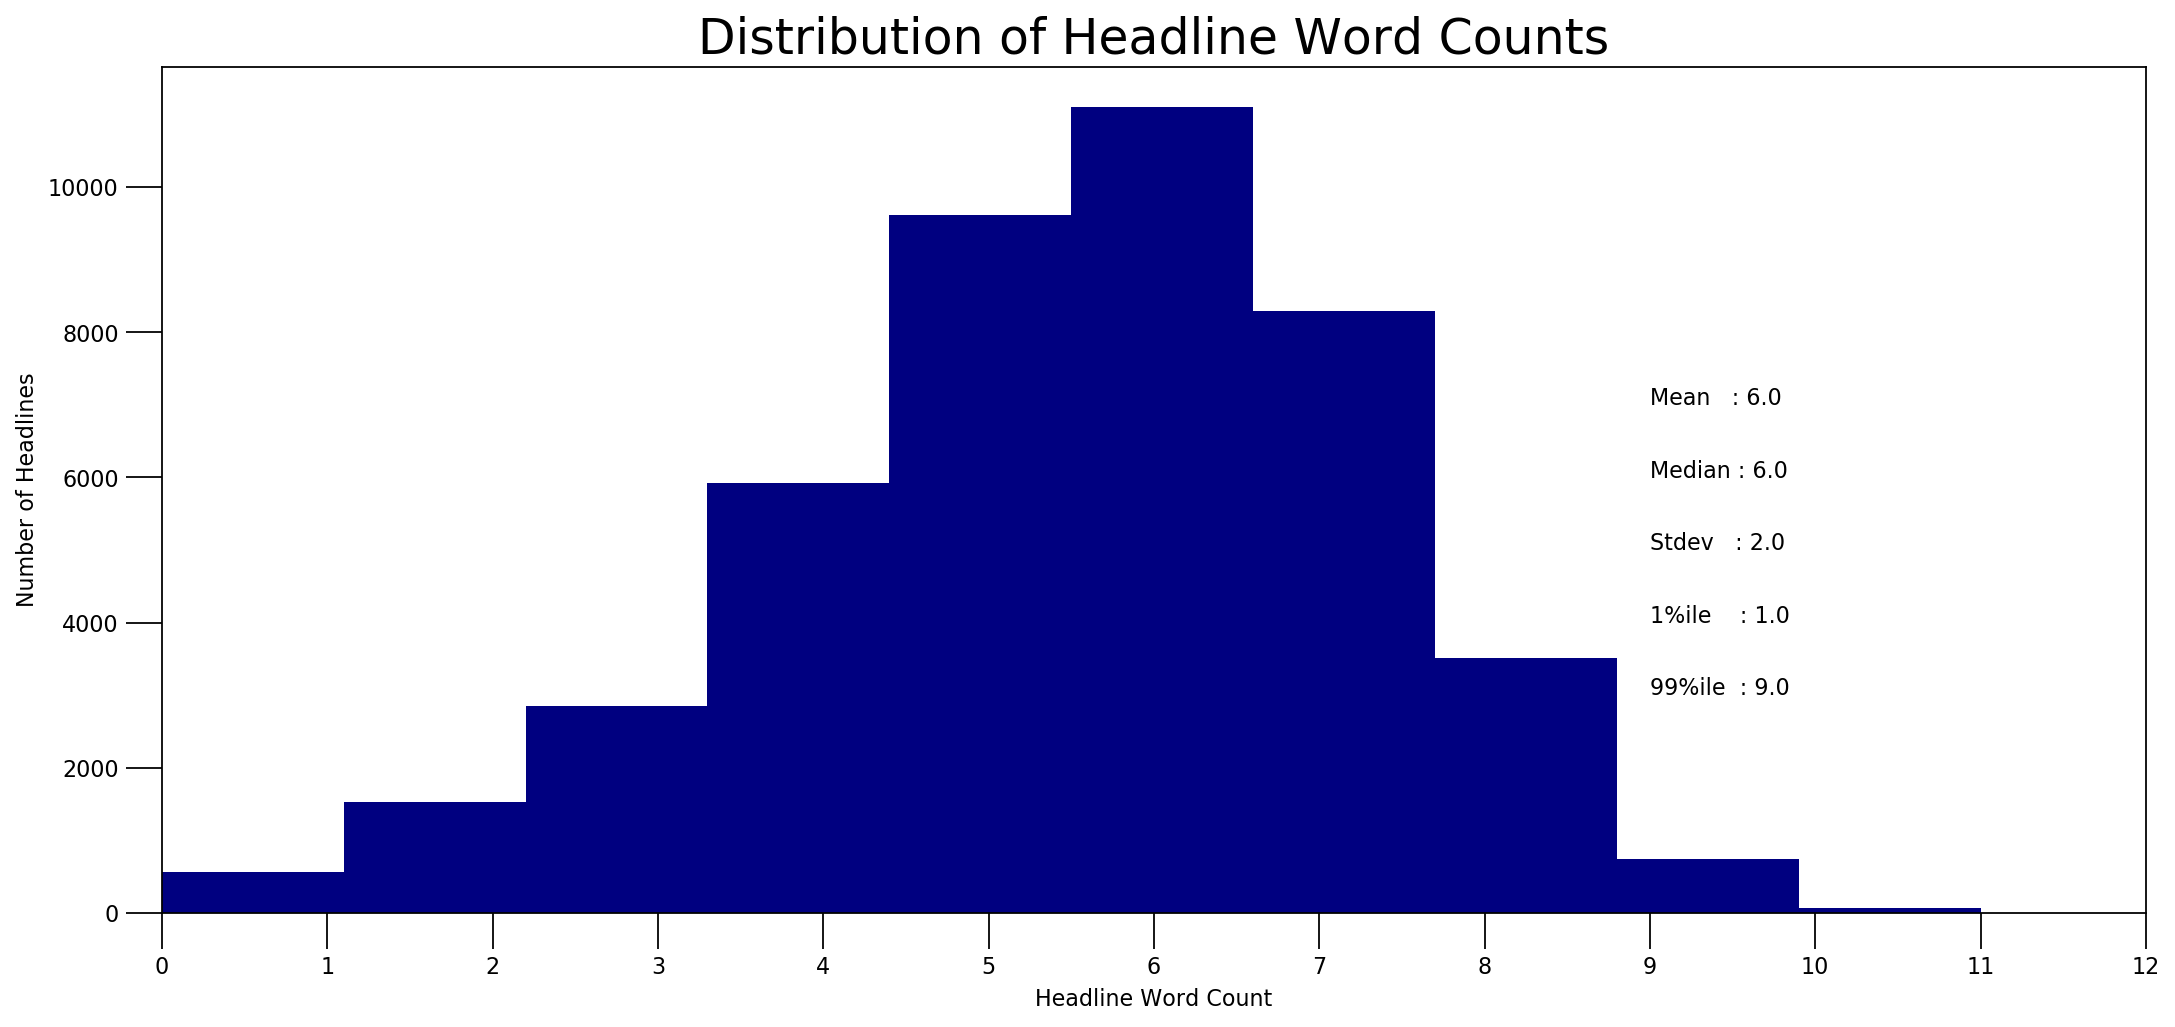

In [87]:
plot_func()

In [88]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

def plot_func():
    fig, axes = plt.subplots(2,2,figsize=(8,6), dpi=160, sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):    
        df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        ax.hist(doc_lens, bins = 10, color=cols[i])
        ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
        sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
        ax.set(xlim=(0, 12), xlabel='Headline Word Count')
        ax.set_ylabel('Number of Headlines', color=cols[i])
        ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    plt.xticks(np.linspace(0,12,13))
    fig.suptitle('Distribution of Headline Word Counts by Dominant Topic', fontsize=22)
    plt.show()

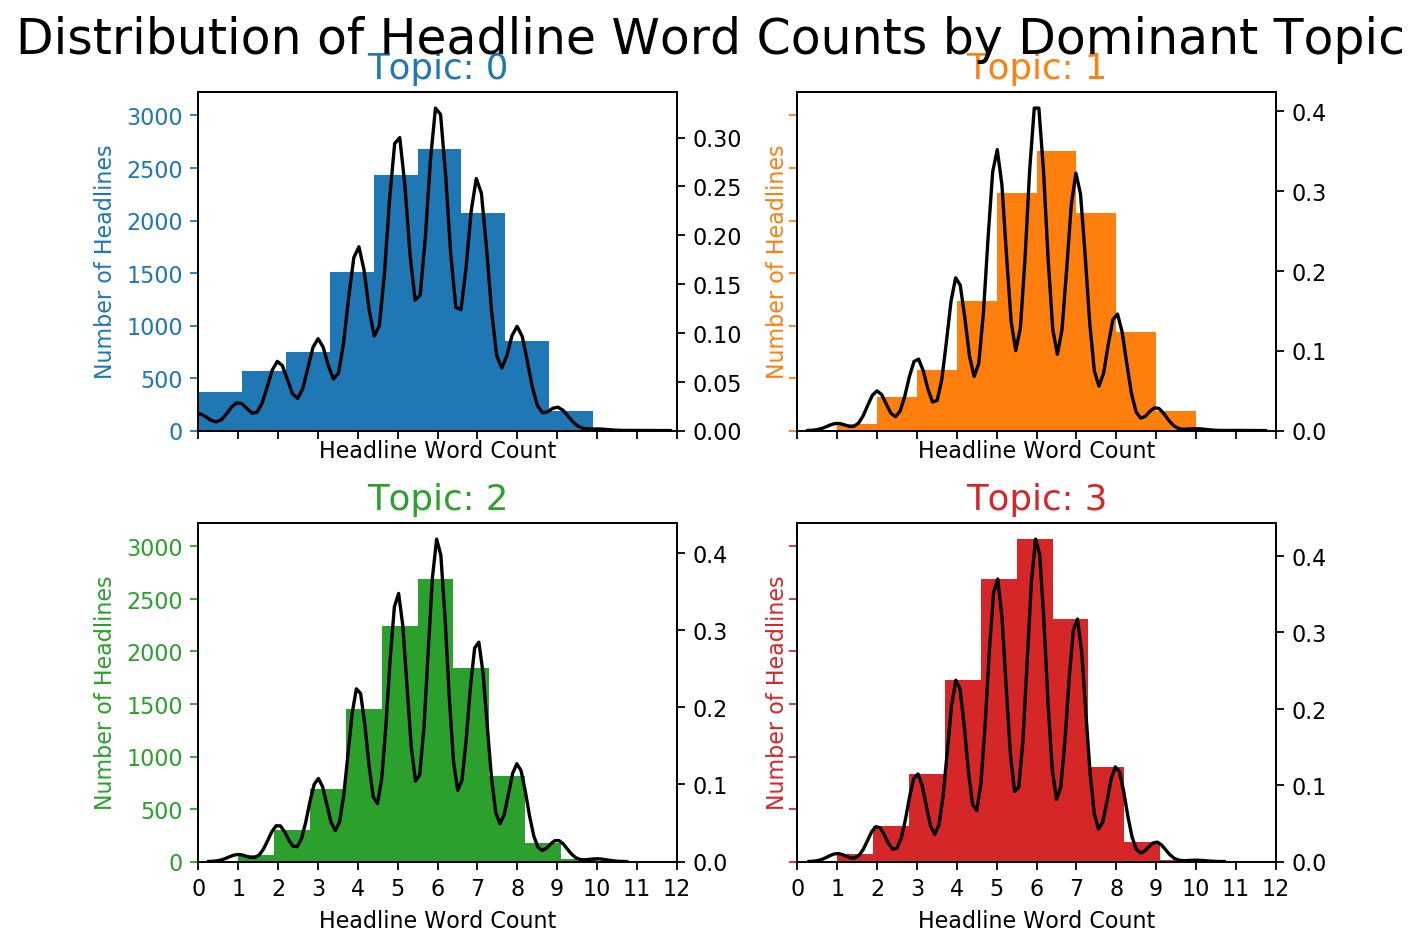

In [89]:
plot_func()

## Word Clouds of Top N Keywords in Each Topic

In [22]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

def show_wordcloud():
    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)
    fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

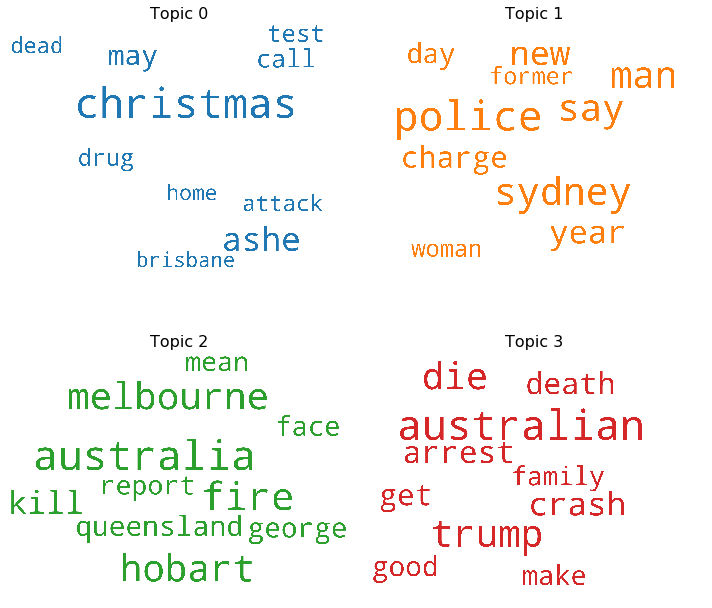

In [23]:
show_wordcloud()    

## Word Counts of Topic Keywords

In [24]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

In [39]:
def show_wordcounts_and_importance():
    
    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.040)
        ax.set_ylim(0, 1800)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.show()

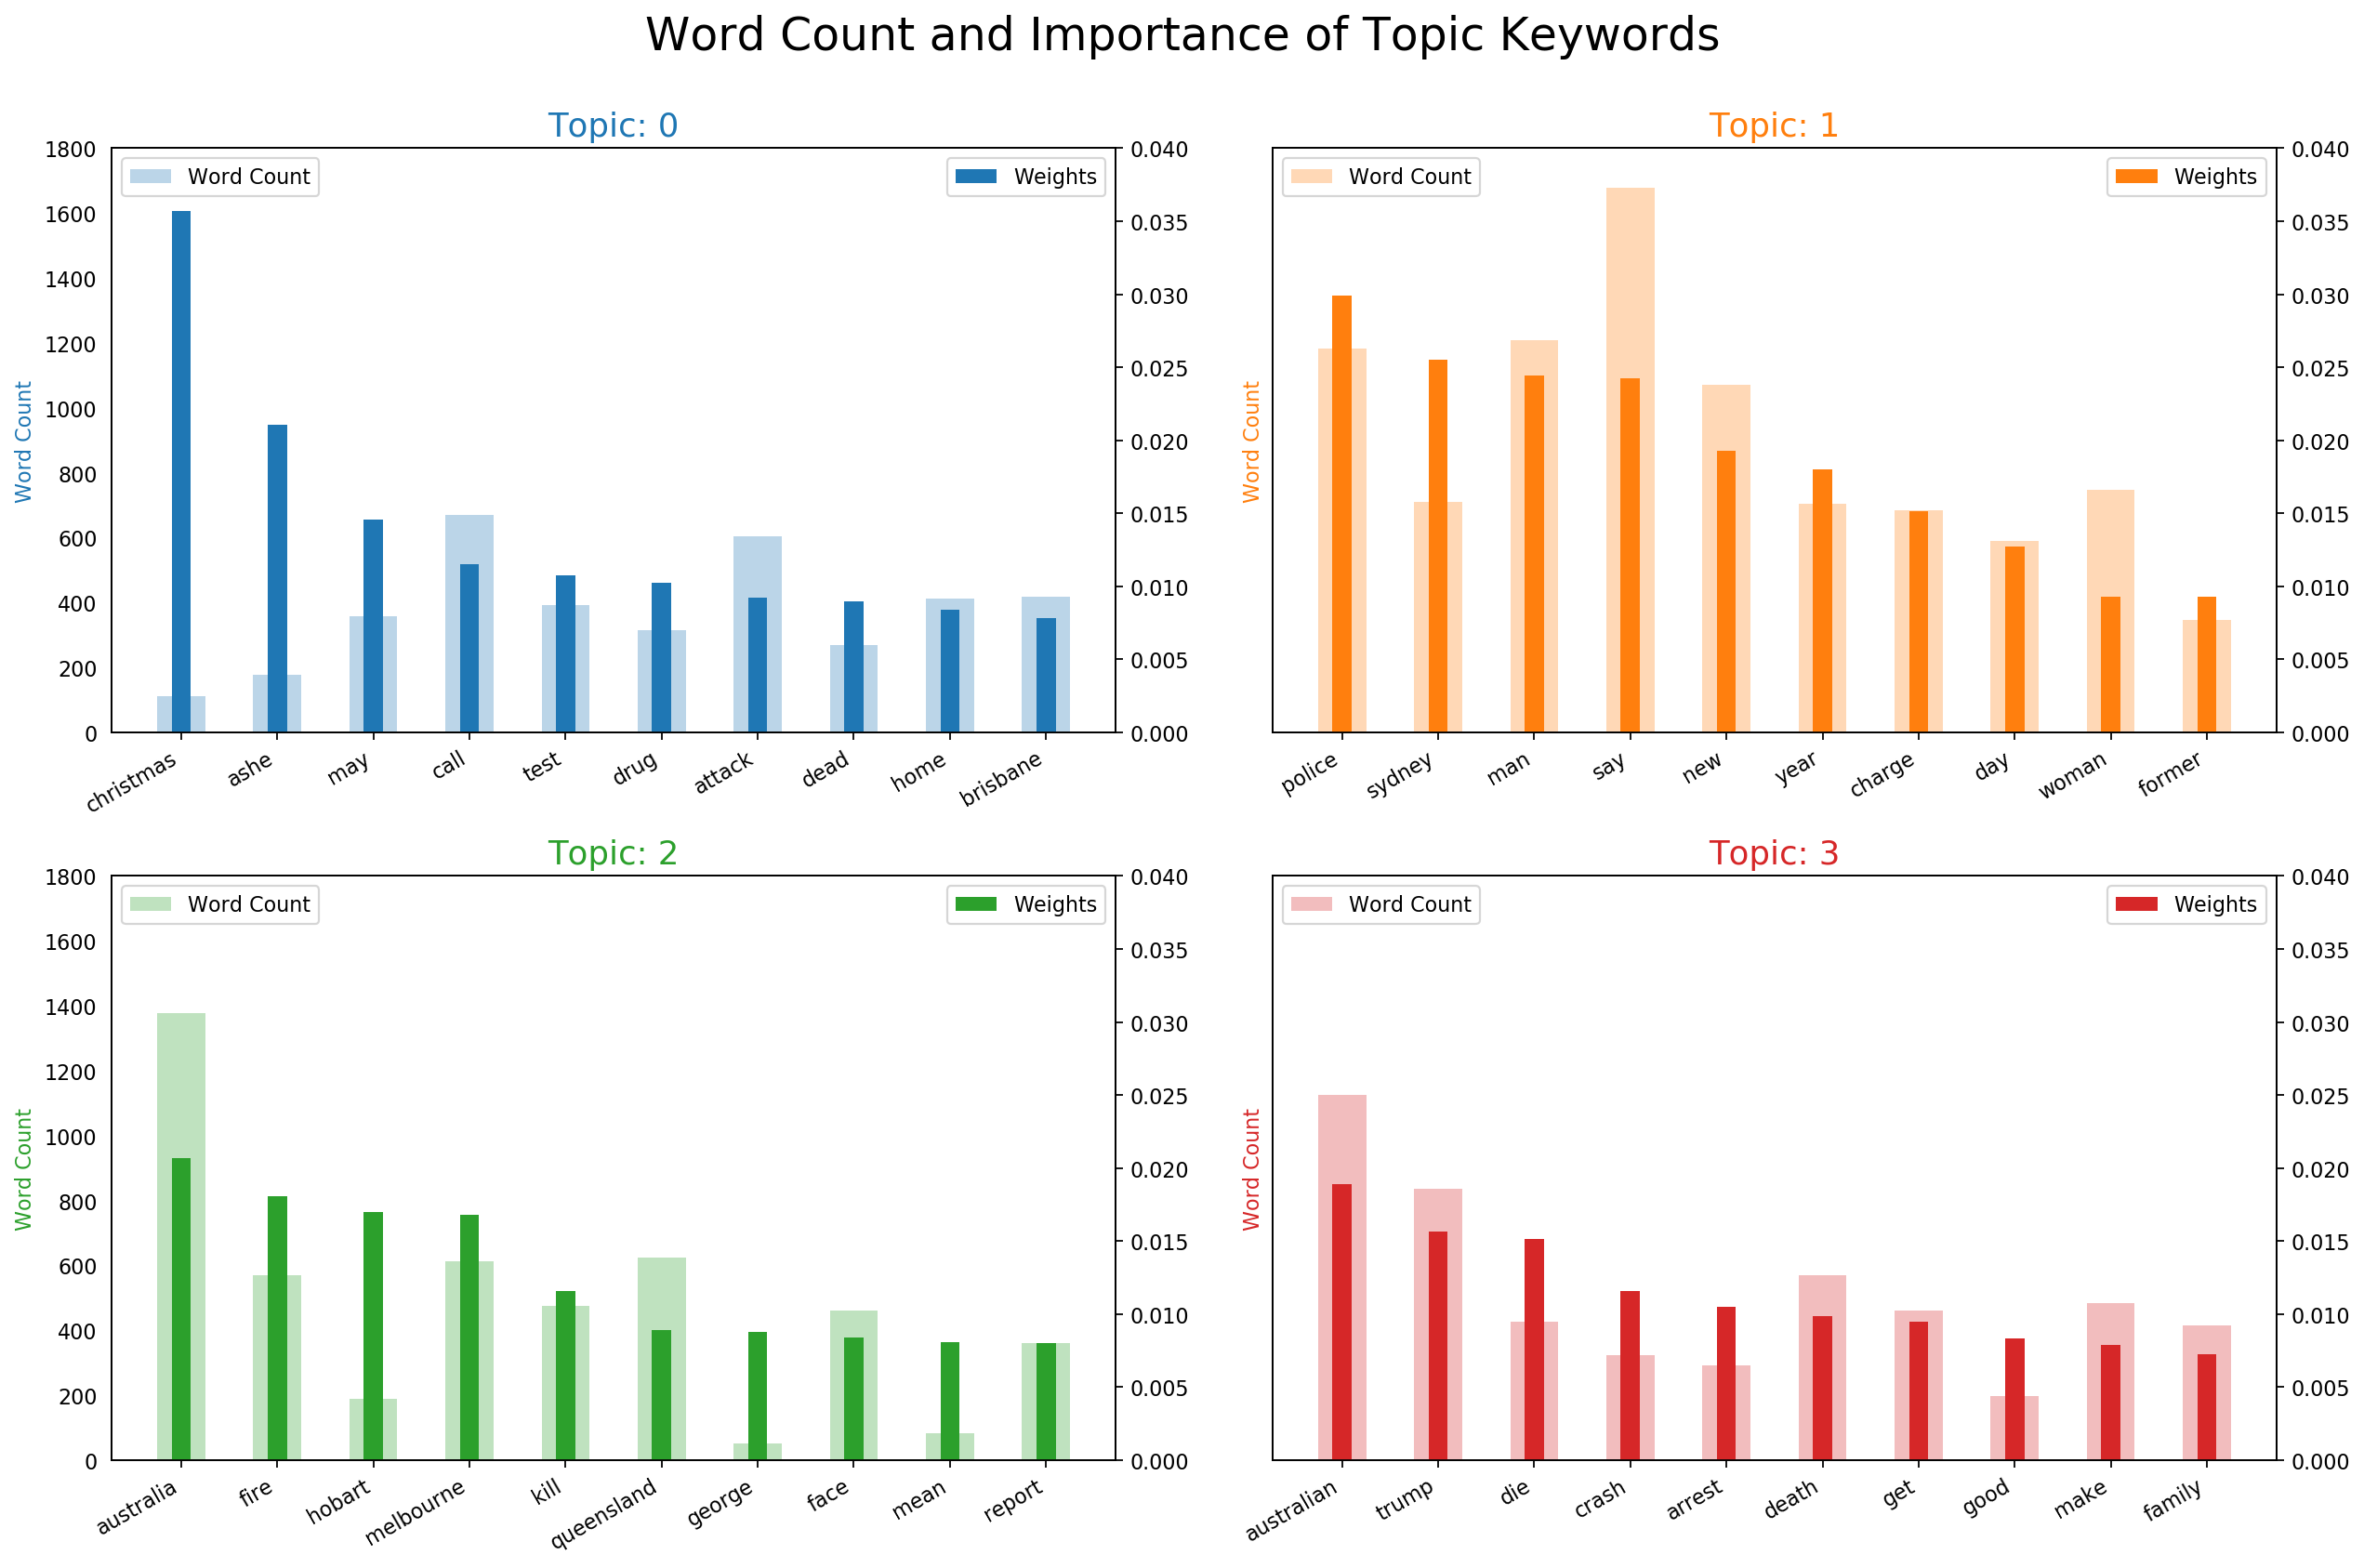

In [40]:
show_wordcounts_and_importance()

## Headline Chart Colored by Topic

In [41]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

In [56]:
def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "H " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    # add custom legend
    topic0_patch = mpatches.Patch(color=mycolors[0], label='Topic 0')
    topic1_patch = mpatches.Patch(color=mycolors[1], label='Topic 1')
    topic2_patch = mpatches.Patch(color=mycolors[2], label='Topic 2')
    topic3_patch = mpatches.Patch(color=mycolors[3], label='Topic 3')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Headlines: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.legend(handles=[topic0_patch, topic1_patch, topic2_patch, topic3_patch],
               loc='lower center')
    plt.tight_layout()
    plt.show()

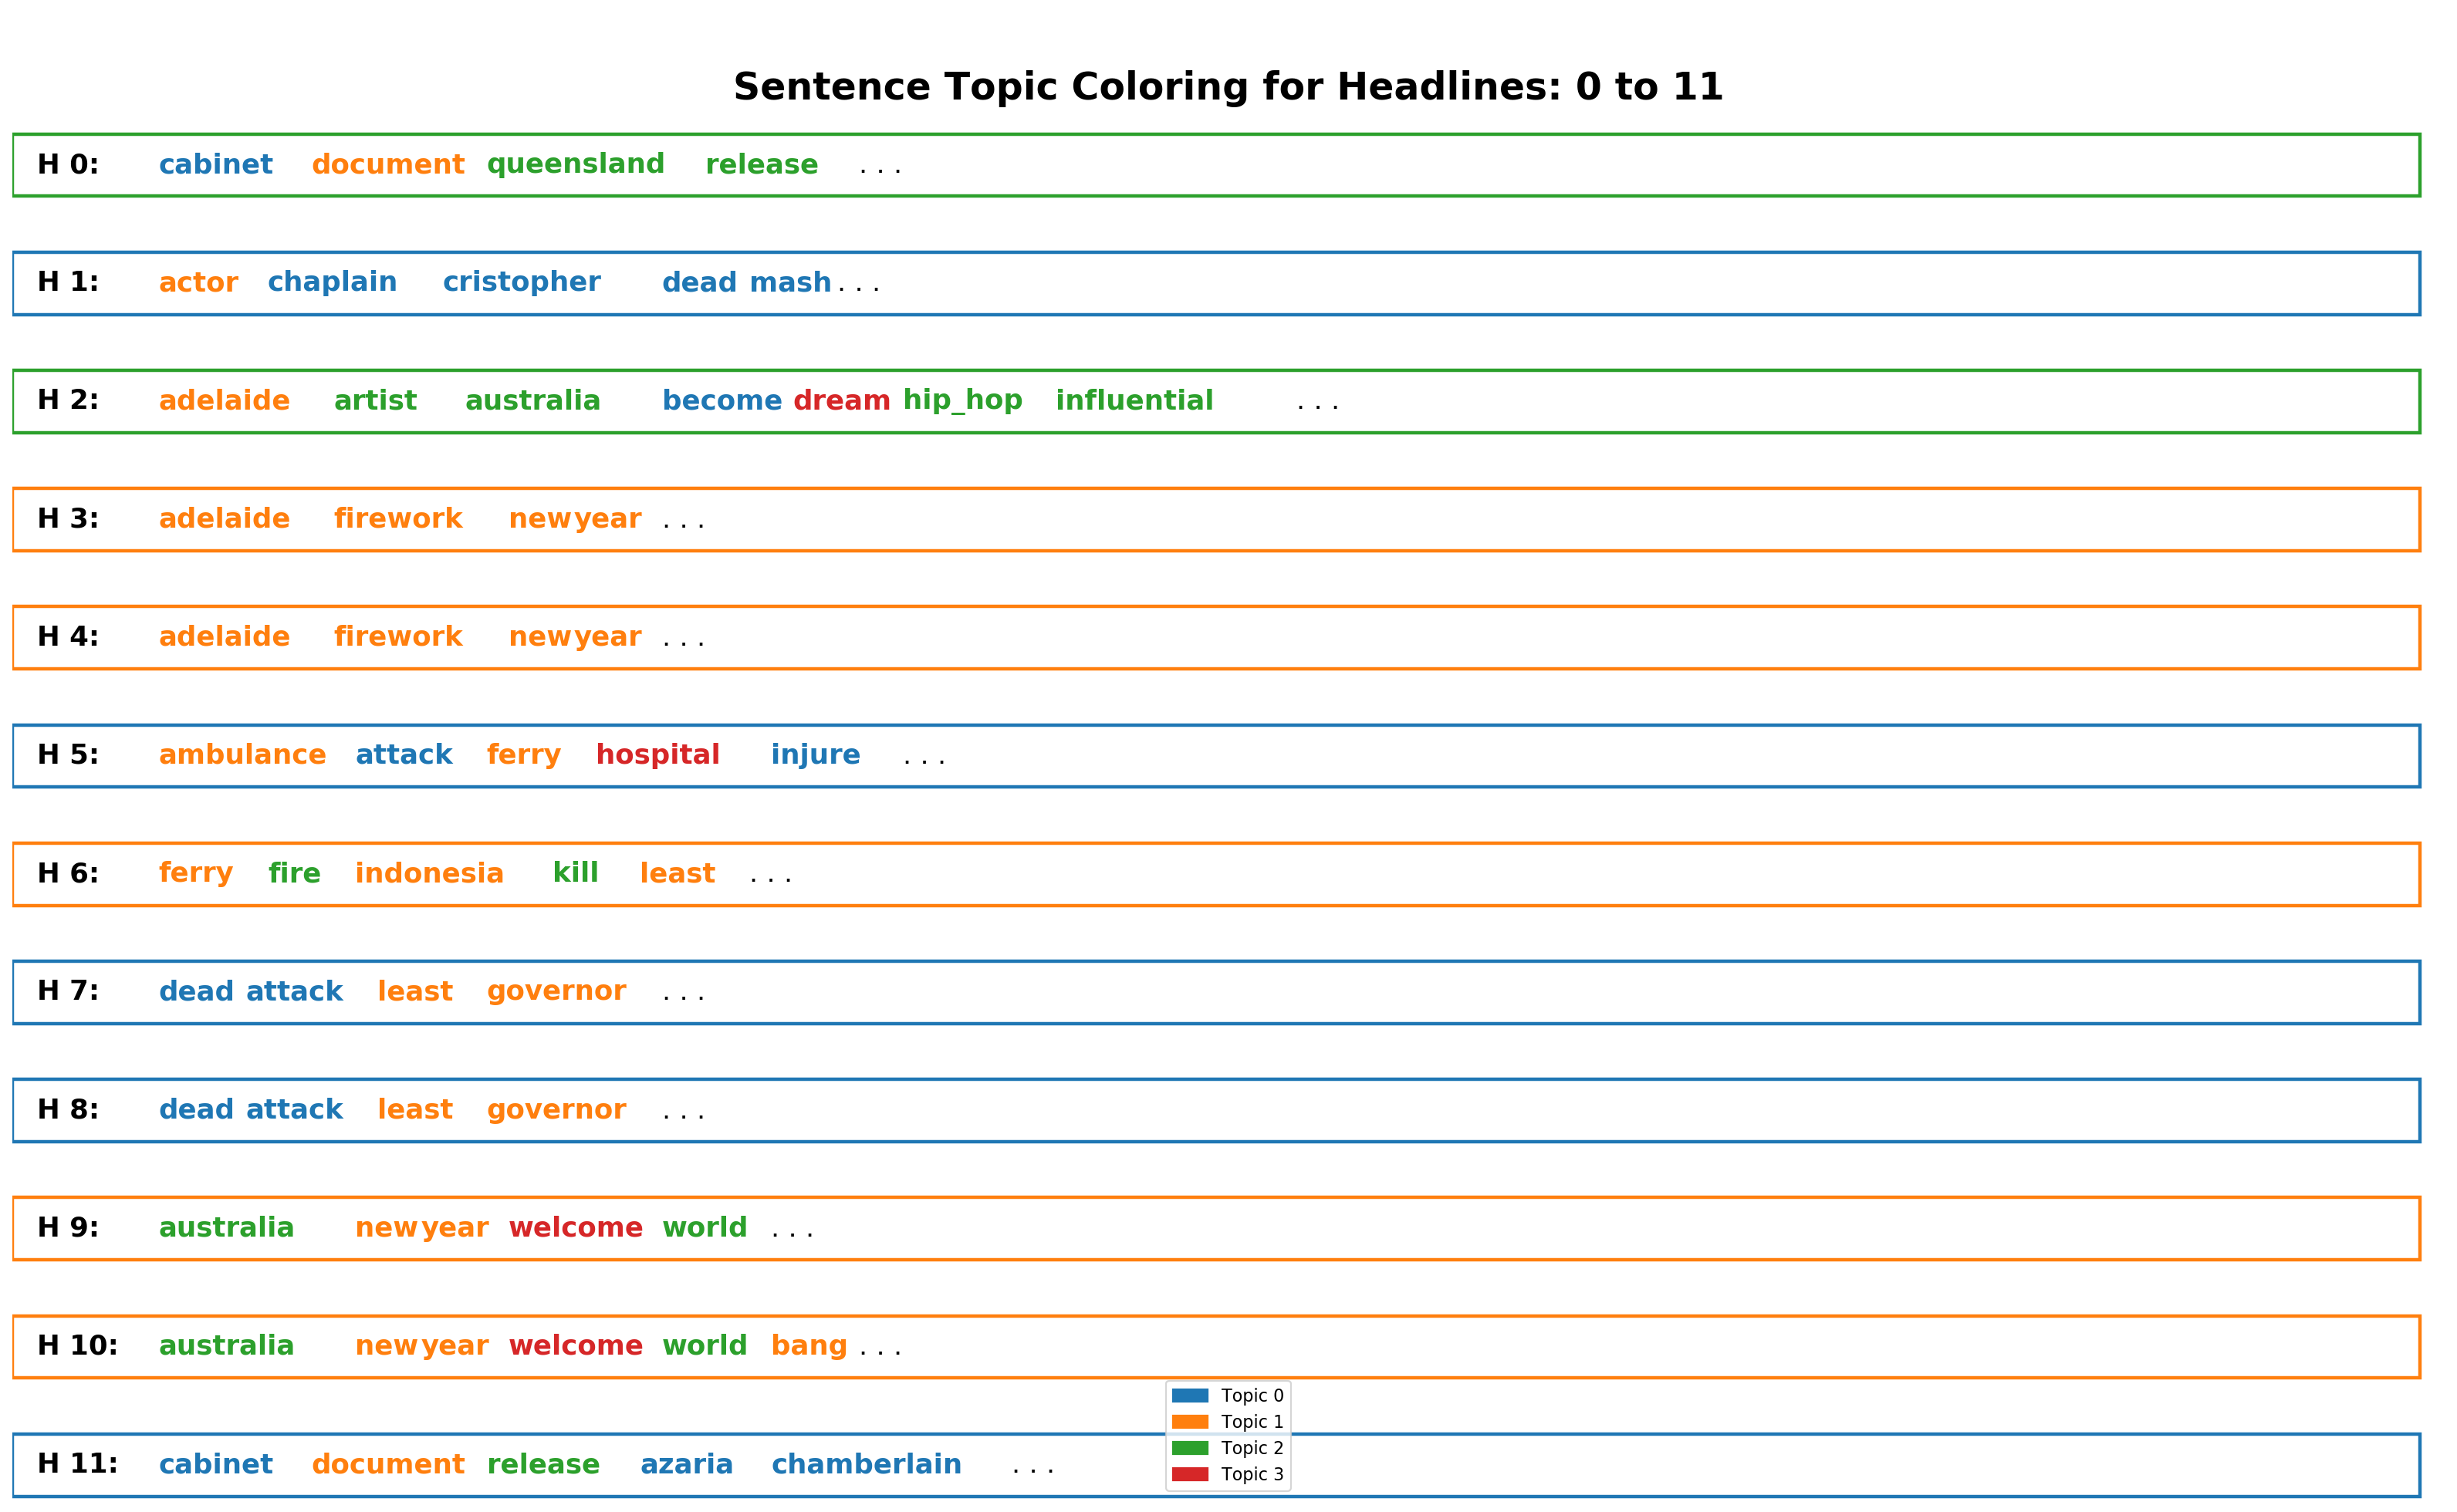

In [57]:
sentences_chart()

## What are the most important topics in the headlines?

In [58]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [63]:
from matplotlib.ticker import FuncFormatter

def plot_func():
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

    # Topic Distribution by Dominant Topics
    ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
    ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
    tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
    ax1.xaxis.set_major_formatter(tick_formatter)
    ax1.set_title('Number of Headlines by Dominant Topic', fontdict=dict(size=10))
    ax1.set_ylabel('Number of Headlines')
    ax1.set_ylim(0, 13000)

    # Topic Distribution by Topic Weights
    ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
    ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
    ax2.xaxis.set_major_formatter(tick_formatter)
    ax2.set_title('Number of Headlines by Topic Weightage', fontdict=dict(size=10))

    plt.show()

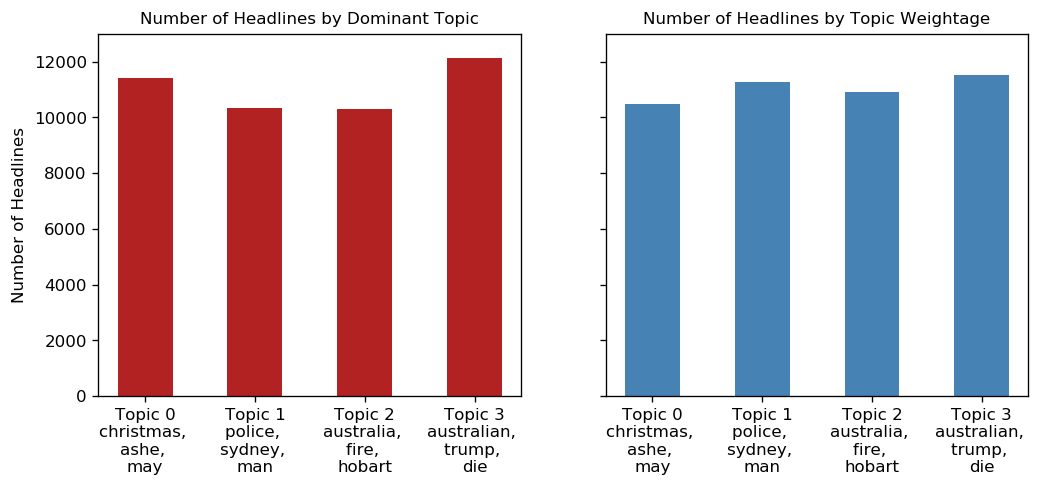

In [64]:
plot_func()

## t-SNE

In [65]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

In [67]:
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40161 samples in 0.026s...
[t-SNE] Computed neighbors for 40161 samples in 0.966s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40161
[t-SNE] Computed conditional probabilities for sample 2000 / 40161
[t-SNE] Computed conditional probabilities for sample 3000 / 40161
[t-SNE] Computed conditional probabilities for sample 4000 / 40161
[t-SNE] Computed conditional probabilities for sample 5000 / 40161
[t-SNE] Computed conditional probabilities for sample 6000 / 40161
[t-SNE] Computed conditional probabilities for sample 7000 / 40161
[t-SNE] Computed conditional probabilities for sample 8000 / 40161
[t-SNE] Computed conditional probabilities for sample 9000 / 40161
[t-SNE] Computed conditional probabilities for sample 10000 / 40161
[t-SNE] Computed conditional probabilities for sample 11000 / 40161
[t-SNE] Computed conditional probabilities for sample 12000 / 40161
[t-SNE] Computed conditional probabilities for sam

In [80]:
def show_tsne_plot():
    # Plot the Topic Clusters
    n_topics = 4
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    plt.figure(figsize=(6, 6), dpi=160)
    for topic_id in range(n_topics):
        plt.scatter(x=tsne_lda[topic_num == topic_id][:,0], 
                    y=tsne_lda[topic_num == topic_id][:,1],
                    color=mycolors[topic_id], 
                    label=f'Topic {topic_id}')
    plt.title("t-SNE Clustering of {} LDA Topics".format(n_topics), fontsize=14)
    plt.legend(fontsize=10)
    plt.show()

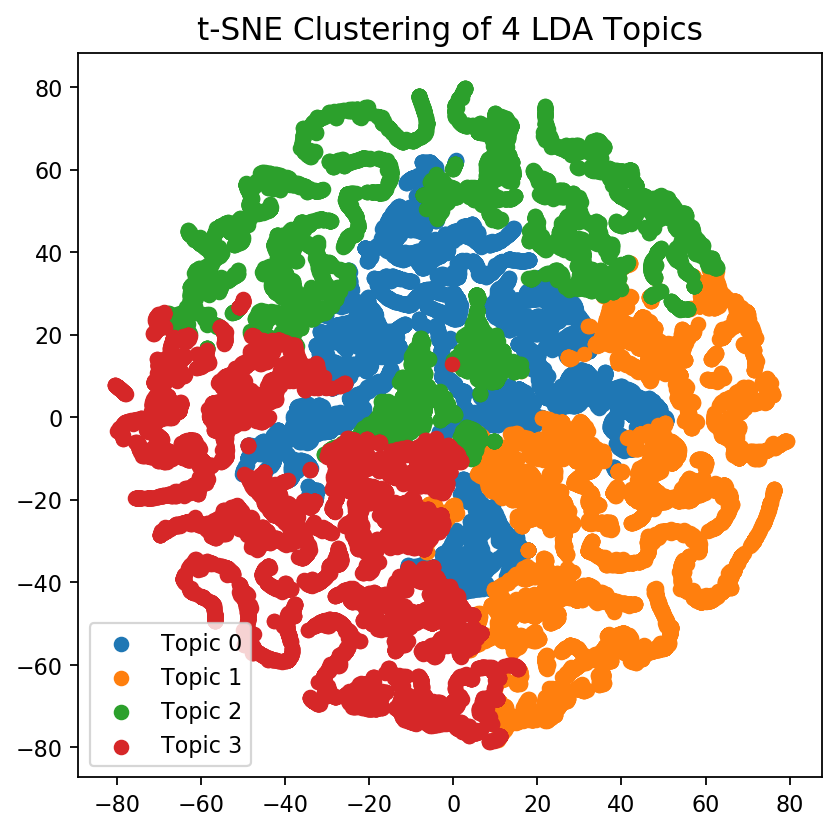

In [81]:
show_tsne_plot()

## Challenges / Issues

- Use more data (more than 1,000,000 samples)

- What is a good number of topics?

- Find topics of *new* text samples

## Useful Sources:

https://radimrehurek.com/gensim/apiref.html